In [40]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from model import Generator, UnetGenerator, UnetGeneratorAdvanced
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


In [87]:
gen_A = Generator(img_channels=3, num_residuals=9).to(device)
gen_B = Generator(img_channels=3, num_residuals=9).to(device)

opt_gen = optim.Adam(
    list(gen_A.parameters()) + list(gen_B.parameters()),
    lr=1e-4,
    betas=(0.9, 0.999)
)

In [88]:
load_checkpoint("saved_model/gen_A.pth.tar", gen_A, opt_gen, 1e-4)
load_checkpoint("saved_model/gen_B.pth.tar", gen_B, opt_gen, 1e-4)

=> Loading checkpoint
=> Loading checkpoint


In [89]:
source_zebra = "horse2zebra/trainB"
source_horse = "horse2zebra/trainA"

zebra_files = os.listdir(source_zebra)
horse_files = os.listdir(source_horse)

In [90]:
transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

### Exemple Zebre vers Cheval

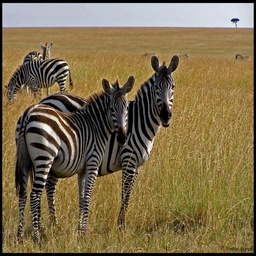

In [95]:
idx_zebra = 7
img_zebra = Image.open(source_zebra+"/"+zebra_files[idx_zebra])
img_zebra

In [96]:
temp = transforms(image=np.array(img_zebra))
img_zebra2 = temp['image'].to(device)
fake_horse = gen_A(img_zebra2)

In [97]:
tensor2pil = T.ToPILImage()

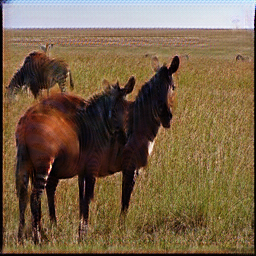

In [98]:
tensor2pil(fake_horse*0.5+0.5)

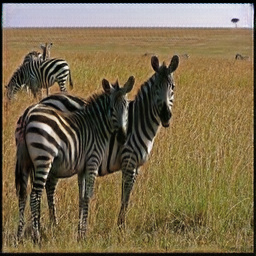

In [99]:
reconstruct_zebra = gen_B(fake_horse)
tensor2pil(reconstruct_zebra*0.5+0.5)

### Exemple Cheval vers Zèbre

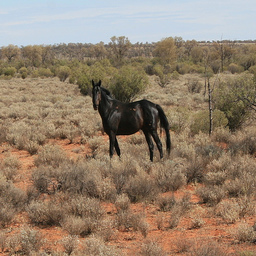

In [108]:
idx_horse = 16
img_horse = Image.open(source_horse+"/"+horse_files[idx_horse])
img_horse

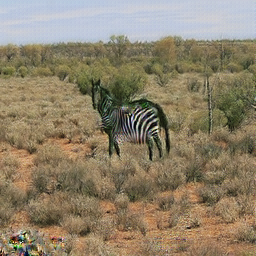

In [109]:
temp = transforms(image=np.array(img_horse))
img_horse2 = temp['image'].to(device)
fake_zebra = gen_B(img_horse2)

tensor2pil(fake_zebra*0.5+0.5)

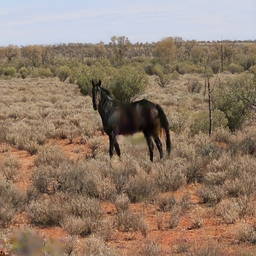

In [110]:
reconstruct_horse = gen_A(fake_zebra)
tensor2pil(reconstruct_horse*0.5+0.5)